# Implementing a Neural Network for CIFAR dataset - Convolutional Networks


## Loading CIFAR dataset

In [ ]:
class_names = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
### Enter you code here
import torch
import torchvision
import torch.nn as nn
import torchvision.transforms as transforms
import torch.optim as optim
from torch.optim import lr_scheduler
from torchvision import datasets, models, transforms
from torch.utils.data.sampler import SubsetRandomSampler
import time
import os
import copy

# applying RandomHorizontalFlip and not vertical
transform_train = transforms.Compose(
    [transforms.RandomHorizontalFlip(),
    transforms.ToTensor()])
# transform_train = transforms.Compose(
#     [transforms.ToTensor()])
transform_val = transforms.Compose(
    [transforms.ToTensor()])

batch_size = 128
image_train = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform_train)
image_val = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform_val)

dataset_sizes={'train': 0, 'test': 0}
dataset_sizes['train'] = len(image_train)
dataset_sizes['val'] = len(image_val)

dataloaders = {
    'train': torch.utils.data.DataLoader(image_train, batch_size=batch_size,
                                             shuffle=True, num_workers=2),
    'val': torch.utils.data.DataLoader(image_val, batch_size=batch_size,
                                          shuffle=False, num_workers=2)
  }

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [ ]:
# Check for the availability of a GPU, and use CPU otherwise
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

## Visualize some of the training images

In [ ]:
inputs, classes = next(iter(dataloaders['train']))
inputs = inputs[0:16]
classes = classes[0:16]

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    inp = np.clip(inp, 0, 1)
    fig = plt.figure(figsize=(5,3), dpi=300)
    plt.imshow(inp)
    if title is not None:
       plt.title(title, fontsize=5)
    plt.pause(0.001)  # pause a bit so that plots are updated

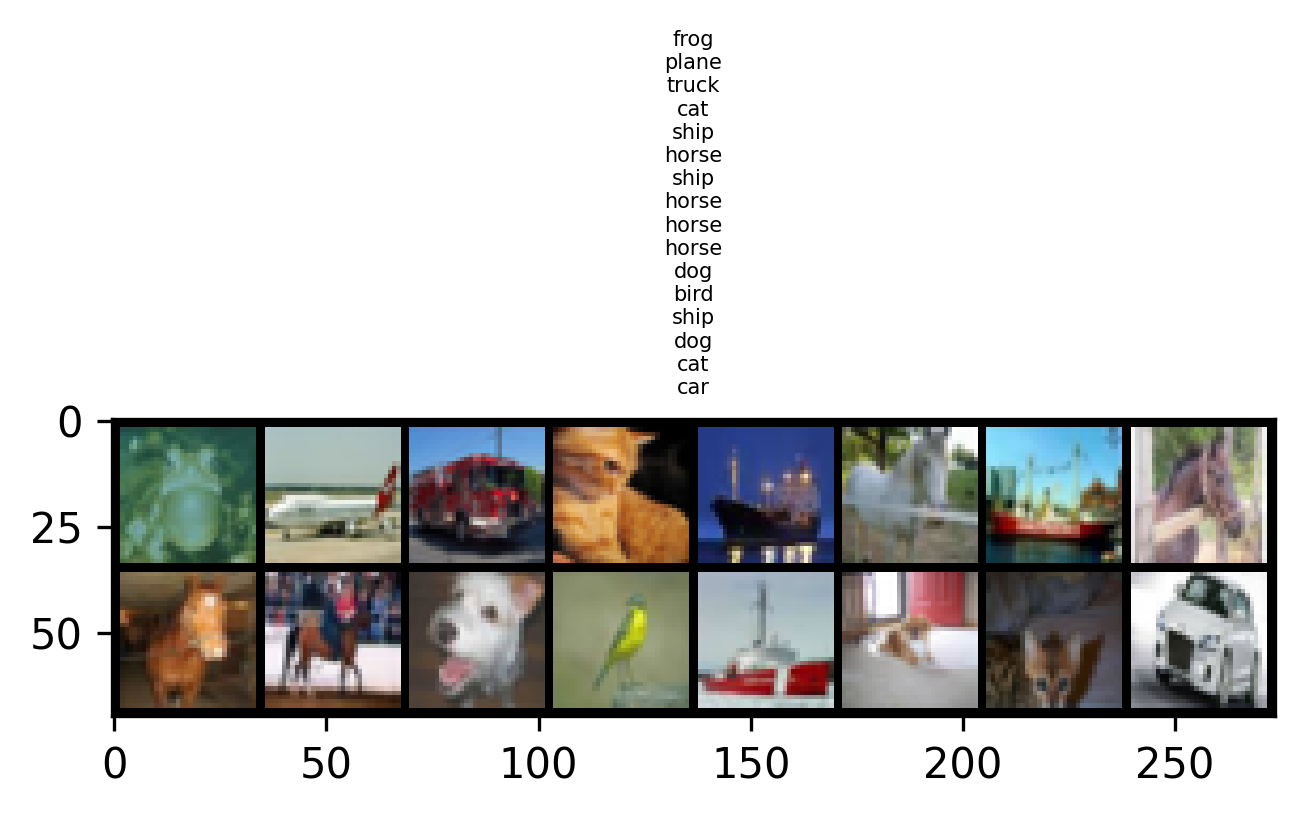

In [ ]:
# Make a grid from batch
out = torchvision.utils.make_grid(inputs, nrow=8)
imshow(out, title='\n'.join([class_names[x] for x in classes]))

## A 2-layer Neural Network

We will define 2-layer network 

In [ ]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.LogSoftmax = nn.LogSoftmax(dim=1)
        # self.linear_relu_stack = nn.Sequential(
        #     nn.Linear(32*32*3, 100),
        #     nn.ReLU(),
        #     nn.Linear(100, 20),
        #     nn.ReLU(),
        #     nn.Linear(20, 10),
        #     # SCHOOL SOLUTION
        #     nn.LogSoftmax(dim=1)
        # )
        ### SCHOOL SOLUTION
        # fully convolutional network. adding batch norm as well - consider adding not at every layer.
        # kernell size are small, number of filters are doubled with every maxpooling
        self.linear_relu_stack = nn.Sequential(
            nn.Conv2d(3,16,kernel_size=3,padding=1,stride=2),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Conv2d(16,32,kernel_size=3,padding=1,stride=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32,64,kernel_size=3,padding=1,stride=2),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64,128,kernel_size=3,padding=1,stride=2),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128,10,kernel_size=3,padding=1,stride=2),
            nn.BatchNorm2d(10),
        )
        # School Solution


    def forward(self, x):
        # working in images of three dimensions (c,w,h) - no flattening needed
        #x = self.flatten(x)
        x = self.linear_relu_stack(x)
        #flattening to have (batch_size,10) instead of (batch_size,10,1,1)
        x = self.flatten(x)
        x = self.LogSoftmax(x)
        return x

In [ ]:
model = NeuralNetwork().to(device)
print(model)

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (LogSoftmax): LogSoftmax(dim=1)
  (linear_relu_stack): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (7): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU()
    (9): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (10): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU()
    (12): Conv2d(128, 10, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (13): BatchNorm2d(10, eps=1e-05, momentum=0.1, affine=True, track_

In [ ]:
#!pip install torchsummary 
from torchsummary import summary
summary(model.to(device), (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 16, 16]             448
       BatchNorm2d-2           [-1, 16, 16, 16]              32
              ReLU-3           [-1, 16, 16, 16]               0
            Conv2d-4             [-1, 32, 8, 8]           4,640
       BatchNorm2d-5             [-1, 32, 8, 8]              64
              ReLU-6             [-1, 32, 8, 8]               0
            Conv2d-7             [-1, 64, 4, 4]          18,496
       BatchNorm2d-8             [-1, 64, 4, 4]             128
              ReLU-9             [-1, 64, 4, 4]               0
           Conv2d-10            [-1, 128, 2, 2]          73,856
      BatchNorm2d-11            [-1, 128, 2, 2]             256
             ReLU-12            [-1, 128, 2, 2]               0
           Conv2d-13             [-1, 10, 1, 1]          11,530
      BatchNorm2d-14             [-1, 1

In [ ]:
# If a GPU is available, make the model use it
model = model.to(device)

# For a multi-class problem, you'd usually prefer CrossEntropyLoss()
# criterion = nn.CrossEntropyLoss()
criterion = nn.NLLLoss()

# Use Stochastic Gradient Descent as the optimizer, with a learning rate of 0.0001 and momentum
# optimizer_ft = optim.SGD(model.parameters(), lr=0.0001, momentum=0.9)
### SCHOOL SOLUTION
optimizer_ft = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=5, gamma=0.1)

num_epochs = 10

In [ ]:
def train_model(model, dataloaders, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    # Init variables that will save info about the best model
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    #School solution
    train_res= np.zeros((2,num_epochs))
    val_res=np.zeros((2,num_epochs))
    dict_res={'train':train_res, 'val':val_res}
    #School solution

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                # Set model to training mode. 
                model.train()  
            else:
                # Set model to evaluate mode. In evaluate mode, we don't perform backprop and don't need to keep the gradients
                model.eval()   

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data
            for inputs, labels in dataloaders[phase]:
                # Prepare the inputs for GPU/CPU
                inputs = inputs.to(device)
                ### SCHOOL SOLUTION
                # inputs = inputs-torch.mean(inputs)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # ===== forward pass ======
                with torch.set_grad_enabled(phase=='train'):
                    # If we're in train mode, we'll track the gradients to allow back-propagation
                    outputs = model(inputs) # apply the model to the inputs. The output is the softmax probability of each class
                    _, preds = torch.max(outputs, 1) # 
                    loss = criterion(outputs, labels)

                    # ==== backward pass + optimizer step ====
                    # This runs only in the training phase
                    if phase == 'train':
                        loss.backward() # Perform a step in the opposite direction of the gradient
                        optimizer.step() # Adapt the optimizer

                # Collect statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                
            if phase == 'train':
                # Adjust the learning rate based on the scheduler
                scheduler.step()  

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            #School solution
            dict_res[phase][0,epoch]=epoch_loss
            dict_res[phase][1,epoch]=epoch_acc
            #School solution

            # Keep the results of the best model so far
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                # deepcopy the model
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {(time_elapsed // 60):.0f}m {(time_elapsed % 60):.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, dict_res

In [ ]:
model,dict_res = train_model(model, 
                    dataloaders,
                       criterion, 
                       optimizer_ft, 
                       exp_lr_scheduler,
                       num_epochs=num_epochs)


Epoch 0/9
----------
train Loss: 1.4741 Acc: 0.4781
val Loss: 1.2869 Acc: 0.5454

Epoch 1/9
----------
train Loss: 1.1652 Acc: 0.5891
val Loss: 1.1339 Acc: 0.6002

Epoch 2/9
----------
train Loss: 1.0146 Acc: 0.6449
val Loss: 1.1411 Acc: 0.6063

Epoch 3/9
----------
train Loss: 0.9186 Acc: 0.6765
val Loss: 1.0304 Acc: 0.6395

Epoch 4/9
----------
train Loss: 0.8461 Acc: 0.7057
val Loss: 0.9996 Acc: 0.6533

Epoch 5/9
----------
train Loss: 0.7260 Acc: 0.7511
val Loss: 0.8369 Acc: 0.7123

Epoch 6/9
----------
train Loss: 0.6910 Acc: 0.7640
val Loss: 0.8166 Acc: 0.7190

Epoch 7/9
----------
train Loss: 0.6761 Acc: 0.7703
val Loss: 0.8158 Acc: 0.7221

Epoch 8/9
----------
train Loss: 0.6594 Acc: 0.7765
val Loss: 0.8078 Acc: 0.7255

Epoch 9/9
----------
train Loss: 0.6479 Acc: 0.7793
val Loss: 0.8139 Acc: 0.7205

Training complete in 2m 35s
Best val Acc: 0.725500


# 2) Debug the training
With the default parameters we provided above, you should get a validation accuracy of about 0.2 on the validation set. This isn't very good.

One strategy for getting insight into what's wrong is to plot the loss function and the accuracies on the training and validation sets during optimization. Write this visualization here.


In [ ]:
#School solution
def plot_convergence(dict_res, num_epochs):
  fig, axes = plt.subplots(1, 2, figsize=(14,4))
  types=['Loss', 'Accuracy']
  plt.subplot(1,2,1); plt.plot(dict_res['train'][0]); plt.plot(dict_res['val'][0]); plt.title('Loss'); plt.legend(['train','val'])
  plt.subplot(1,2,2); plt.plot(dict_res['train'][1]); plt.plot(dict_res['val'][1]); plt.title('Accuracy'); plt.legend(['train','val'])
#School solution


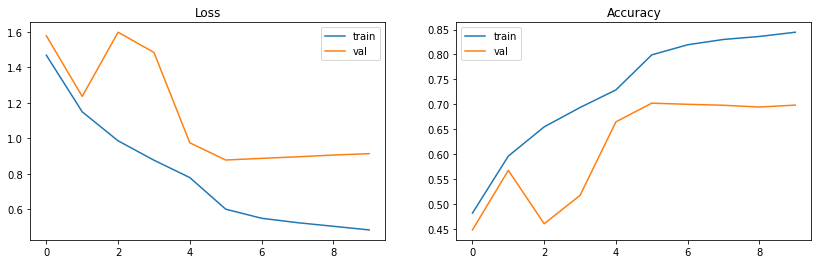

In [ ]:
#School solution
plot_convergence(dict_res,num_epochs ); plt.show()
# my network - overfits. no augmentation.
# Train 0.84
# Test 0.7

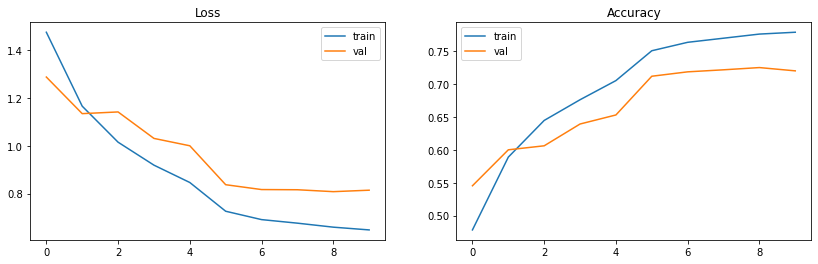

In [ ]:
#School solution
plot_convergence(dict_res,num_epochs ); plt.show()
# # my network - augmentation.
# Train 77
# Test 72